# Dealing with Medical Data

Tutorial by Pedro Borges

The goal of this notebook is to take you through some common strategies used to pre-process medical imaging data prior to training with convolutional neural networks.

Medical image datasets present specific challenges for convolutional deep learning as they are typically small in number, while large in image dimensions. The images themselves are complex and incredibly difficult to read for non clinical experts and presentations of disease may be highly heterogenous.

Let's start by pip installing the `SimpleITK` python package for medical image processing; then then defining some plotting functions which will use for some of our analyses

In [1]:
%matplotlib inline
!pip3 install SimpleITK

     |████████████████████████████████| 47.4MB 94kB/s 


In [2]:
# Setting up various plot functions to be used throughout the notebook
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_images(images, title=None, figsize=(15,15)):
    f, axes = plt.subplots(1, len(images), figsize=figsize)
    for image_id, image in enumerate(images):
        axes[image_id].imshow(image, cmap='gray')
        axes[image_id].axis('off')
        if not title:
            axes[image_id].set_title('Image {}'.format(image_id), fontsize=20)
        elif len(title) == 1:
            axes[image_id].set_title('Image {}: {}'.format(image_id, title[0]), fontsize=20)
        else:
            axes[image_id].set_title('Image {}: {}'.format(image_id, title[image_id]), fontsize=20)
    f.tight_layout()


def plot_grids(grids, figsize=(15,15)):
    f, axes = plt.subplots(1, len(grids), figsize=figsize)
    for grid_id, grid in enumerate(grids):
        grid_array = sitk.GetArrayViewFromImage(grid)
        axes[grid_id].imshow(np.flip(grid_array, axis=0),
               interpolation='hamming',
               cmap='gray',
               origin='lower')
        axes[grid_id].axis('off')
        axes[grid_id].set_title('Grid {}'.format(grid_id), fontsize=20)
    f.tight_layout()
  

def plot_grids_and_images(grids, images, figsize=(15,15)):
    f, axes = plt.subplots(1, len(grids), figsize=figsize)
    for grid_id, grid in enumerate(grids):
        grid_array = sitk.GetArrayViewFromImage(grid)
        axes[grid_id].imshow(np.flip(grid_array/np.max(grid_array)*images[grid_id]/np.max(images[grid_id]), axis=0),
               interpolation=None,
               cmap='gray',
               origin='lower')
        axes[grid_id].axis('off')
        axes[grid_id].set_title('Grid overlay {}'.format(grid_id), fontsize=20)
    f.tight_layout()


def plot_histograms(images, figsize=(15,7.5)):
    f, axes = plt.subplots(1, len(images), figsize=figsize)
    for image_id, image in enumerate(images):
        histogram, bins = np.histogram(image, bins=40)
        axes[image_id].set_xlim([0, 120])
        axes[image_id].hist(histogram, bins)
        axes[image_id].set_title('Image {} Histogram'.format(image_id), fontsize=20)
    f.tight_layout()

Next we will download and unpack an example hippocampus MRI dataset, which we will use for our experiments. The hippocampus is a brain structure involved in processing and storing memories. It is known to be one of the first brain areas artophed by Alzheimer's disease

In [3]:
file_download_link = "https://github.com/pedrob37/AML_Lecture4/blob/master/Task04_Hippocampus.tar?raw=true"
!wget -O Task04_Hippocampus.tar --no-check-certificate "$file_download_link"
!tar -xf Task04_Hippocampus.tar

--2021-02-03 09:18:30--  https://github.com/pedrob37/AML_Lecture4/blob/master/Task04_Hippocampus.tar?raw=true
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/pedrob37/AML-Lecture-materials/blob/master/Task04_Hippocampus.tar?raw=true [following]
--2021-02-03 09:18:30--  https://github.com/pedrob37/AML-Lecture-materials/blob/master/Task04_Hippocampus.tar?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pedrob37/AML-Lecture-materials/raw/master/Task04_Hippocampus.tar [following]
--2021-02-03 09:18:31--  https://github.com/pedrob37/AML-Lecture-materials/raw/master/Task04_Hippocampus.tar
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pedrob37/AML-Lec

If the above cell did not download the data properly (i.e.: You do not see a FOLDER named Task04_Hippocampus.tar) then it's likely download quoatas have been exceeded. If that's the case then please download the data from: https://drive.google.com/drive/folders/1HqEgzS8BV2c7xYNrZdEAnrHk7osJJ--2 (You want the folder named Task04_Hippocampus.tar). Just upload it to this notebook and run:
> !tar -xf Task04_Hippocampus.tar  

 and you should be good to go.

## Exercise 1 Histogram Normalisation

Some types of medical scan are non-quamtitative. In other words the intensity distribution represent relative differences between different types of tissue rather than a quantitative measure of, for example, radioisotopes uptake, as seen in PET. This presents problems as the distriubutions may change from scanner to scanner or sequence to sequence, making it difficult to train on datasets acquired from multiple sites.

Magnetic Resonance Image (MRI) is one example of (generally) non-quantitative scan which nonetheless has many strengths as a non invasive imaging modality, capable of distinguishing across many different types of tissue at many different scales.

One approach to standardising MRI scans, to make images acquired across different scanners (but common protocols) make images more consistent is to perform histogram matching, so as to rescale image intensity distributions to match that of a standardised target distribution. In this notebook, We will go through the step by step process of histogram normalisation for a hippocampus dataset. 
  
While histogram normalisation can be done on a case-by-case basis, given a dataset spanning a number of subjects we would like to normalise them all to a common space. This can be accomplished according to the details in [this](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.204.102&rep=rep1&type=pdf) paper, the main details of which we'll cover here.  

The process is as follows: 

1. First chose a range of percentiles to map between, e.g.: 10, 20, 30, 40, ..., 90 
2. Calculate intensity values at each percentiles for each of the "train" images, we will call these the landmarks
3. Choose additional percentiles to act as the [min, max] of the range (e.g. here 5 and 95 (we assume below 5 and above 95 it represents noise). Scale the intensities corresponding to this range to the target ("standard") scale (e.g.: [0, 100]) using interpolation.
4. Next apply the same scaling operation to each landmark
5. Estimate landmark intensities for all images and average to get a target set of average landmark intensities (one for each percentile in our original list)
6. Finally, take each image and scale its intensities to match the target (landmark) percentile scale 

You will want to read how these two functions work to complete the exercise:
1. [np.percentile](https://docs.scipy.org/doc/numpy/reference/generated/numpy.percentile.html)
2. [interp1d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html)

Let's first begin by just loading in the dataset:

In [4]:
import nibabel as nib
import os

def read_file(filename):
    img = nib.load(filename)
    data = img.get_fdata()
    aff = img.affine
    return data, aff

# Build the 2D dataset: Let's take 20 images
dataset = []
data_dir = 'Task04_Hippocampus/imagesTr'
images = os.listdir(data_dir)
for entry in range(20):
    image, _ = read_file(data_dir + '/' + images[entry])
    # Let's take the middle slice and normalise
    dataset.append(100 * image[:, :, 17] / np.max(image[:, :, 17]))

**To do 1.1** Using the step by step instructions above; starting from 1.2 "Calculate intensity values at each percentiles for each of the "train" images", implement histogram matching.


In [5]:
import numpy as np
from scipy.interpolate import interp1d

# function for estimation of of landmark (intensities) to match a list of percentiles
def calc_landmarks_from_percentiles(image, percentile_list):
    '''
    function for estimation of of landmark (intensities) to match a list of percentiles
    input:
      image - image array for which we wish to estimate intensity (landmarks)
      percentile_list - list of percentiles e.g. [10,20,30....90] for which we want corresponding intensities

      output: array containing the value of the intensity distribution for each percentile in the list
    '''
    landmarks = np.percentile(image, percentile_list)
    return landmarks

def create_trained_mapping(images, percentile_list, scale_min, scale_max, p_min, p_max):
    '''
    function for estimating average landmarks for target population
    input:
      images - list of all images in the target population
      percentile_list - list of percentiles e.g. [10,20,30....90] for which we want corresponding intensities
      scale_min - the minimum of the target range (where we wish to rescale intensities corresponding to the p_min and p_max percentile of the input to)
      scale_max -maximum of the target range
      p_min - the lowest percentile of the input that we consider true signal (and wish to map to a standard scale)
      p_max  the maximumpercentile of the input that we consider true signal 

      output: array containing the value of the intensity distribution for each percentile in the list
    '''
    average_mapped_landmarks = np.zeros(len(percentile_list),)
    for image in images:
        # 1.2. Calculate the landmarks for each image
        landmarks = calc_landmarks_from_percentiles(image, percentile_list)
        # 1.3.  Calculate the image intensities corresponding to the o_min and p_max percentile
        # of the disribution. These will anchor the mapping
        intensity_min = np.percentile(image, p_min)
        intensity_max = np.percentile(image, p_max)
        # 1.4. Create mapping by interpolating between the image's intensity_min + intensity_min_max values
        # to those of the standard scale [scale_min, _scale max]
        # **hint** using interp1d to rescale from current range to target range
        mapping = interp1d([intensity_min, intensity_max], [scale_min, scale_max], fill_value='extrapolate')
        # 1.5. Map the image landmarks to these values (apply mapping to landmarks)
        mapped_landmarks = np.array(mapping(landmarks))
        # Sum the mapped landmarks iteratively
        average_mapped_landmarks += mapped_landmarks
    # Average the summed landmarks
    average_mapped_landmarks = average_mapped_landmarks / len(images)
    return average_mapped_landmarks



**To do 1.6** Now that we've coded the mapping training function, tcode a function that applies the learned mapping to a new image, and test the method:

Means of original images: 46.507495246437024 43.86787018522089 43.57182753515001 Variances: 734.0163925016554 638.1138158549417 472.7493928137462
Means of normalised images: 51.11030755431435 51.200385121788294 51.47236410194735 Variances: 970.873051925529 971.5161385501917 1030.5375929365607


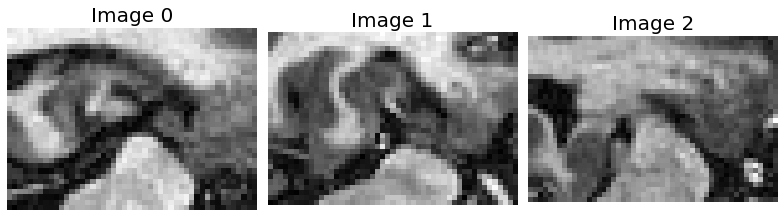

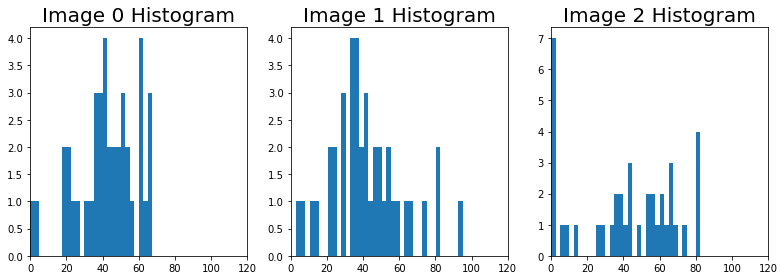

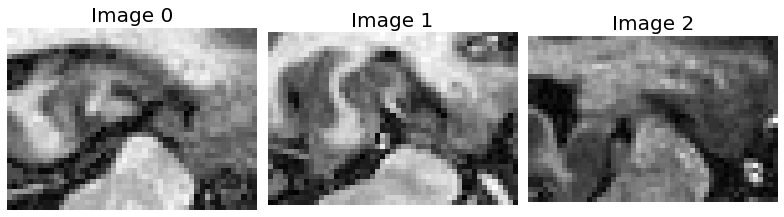

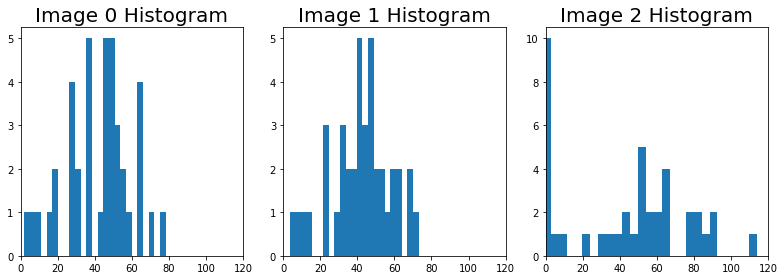

In [20]:
# 1.6. Code function to apply mapped landmarks to a new image
def standardise_image(image, percentile_list, average_mapped_landmarks):
    # 1.6.1 Calculate the landmarks corresponding to the *same* percentile list as above
    # But now for the image you wish to standardise to the target distribution
    # *Hint* will therefore need to apply same function as before
    landmarks = calc_landmarks_from_percentiles(image, percentile_list)
    # Calculate mapping between the landmarks of this image and the averaged mapped landmarks
    # using intep1d (as before)
    mapping = interp1d(landmarks, average_mapped_landmarks, fill_value='extrapolate')
    # Apply this mapping to the new image (as before)
    new_image = mapping(image)
    return new_image


# Test the method
percentile_list = [10, 20, 30, 40, 50, 60, 70, 80, 90] # 1.1 - setting the target list of percentiles
# estimating the average landamrks across the population
# here using all but the first three images in the list; target range [0,100] p_min=5; p_max=95
trained_mapping = create_trained_mapping(images=dataset[3:],
                                         percentile_list = percentile_list,
                                         scale_min=0, scale_max=100,
                                         p_min=5, p_max=95)

normalised_images = []
for image in dataset[0:3]:
    normalised_images.append(standardise_image(image, percentile_list, trained_mapping))

# Before
plot_images(dataset[0:3], figsize=(11, 11))
plot_histograms(dataset[0:3], figsize=(11, 4))

# making a rough approximation that the distributions are Gaussian to compare statistics before and after normalisation
print('Means of original images:', np.mean(dataset[0]),np.mean(dataset[1]),np.mean(dataset[2]),'Variances:',np.var(dataset[0]),np.var(dataset[1]),np.var(dataset[2]))

# After
plot_images(normalised_images, figsize=(11, 11))
plot_histograms(normalised_images, figsize=(11, 4))
print('Means of normalised images:', np.mean(normalised_images[0]),np.mean(normalised_images[1]),np.mean(normalised_images[2]),'Variances:',np.var(normalised_images[0]),np.var(normalised_images[1]),np.var(normalised_images[2]),)

# Exercise 2. Augmentations
Deep learning is very much data driven, and augmentations allow us to increase the size of our dataset aritifically by modifying the appearance of existing images, increasing the robustness of trained networks. We will go through and implement some of the most widely used augmentations in medical imaging:
1. Flipping
2. Rotations
3. Bias field 
4. Noise
5. Elastic field deformations  
  
### 2.1 Flipping and rotations
These augmentations are self-explanatory, new images can be generated via horizontal/ vertical flipping and/ or rotating them by some number of degrees. Let's begin by looking at some un-augmented images from our brain dataset:

**To do** Let's implement a flip, a rotation, and both a flip and rotation on these images. Code a function for each and run on the sample images

- 2.1.1 For the flip augmentation:
  -  create a variable, *flip_prob*, that determines the probability that any axis in the image will be flipped.
  - If a random generated number is above the threshold for thax axis flip it **hint** [Numpy flip](https://www.google.com/search?q=numpy+flip&oq=numpy+flip&aqs=chrome.0.69i59l2j0l5j69i60.1504j1j7&sourceid=chrome&ie=UTF-8)  
- 2.1.1 For the rotation:
  -  a *max_rot_angle* is passed which stipulates the maximum rotation in either direction (2D).
  - implement rotation and resampling to the regular grid using [Scipy image rotate](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.rotate.html) (note the import has already been included at the top of the cell.)


**Note (for future use)**: Interpolation has to be considered carefully when carrying out rotations. *scipy.ndimage.rotate* uses spline interpolation, using [piecewise](https://en.wikipedia.org/wiki/Piecewise) polynomials to interpolate between points. The *order* parameter sets the order of the polynomials that are used. By default this parameter is set to three (Corresponding to cubic splines), BUT this is not suitable when dealing with, for example, segmentation labels: In this case we will use an order zero spline, or *nearest neighbour* because we don't want any new values not found in the original to be introduced.

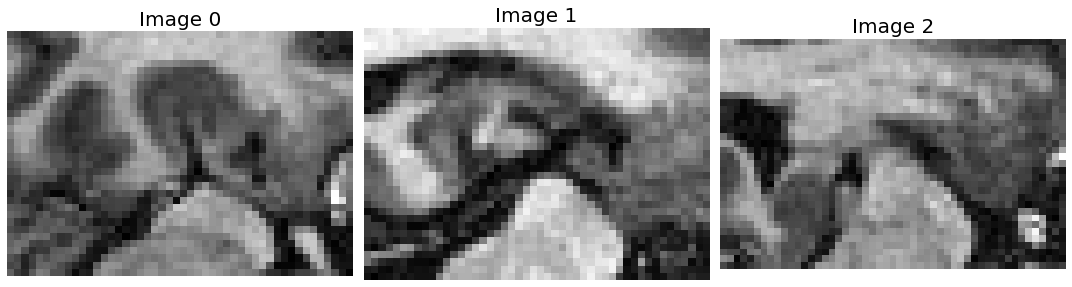

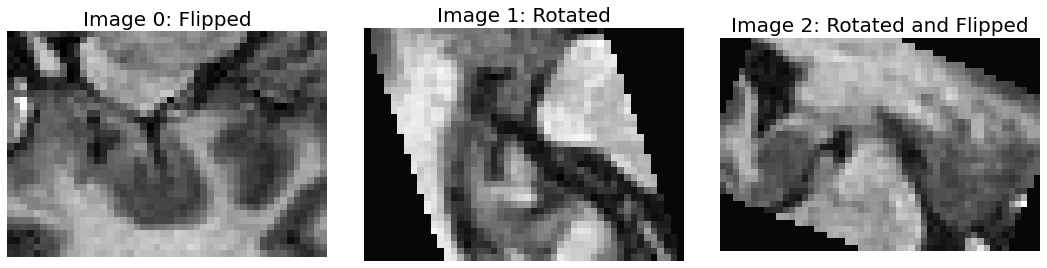

In [ ]:
import scipy.ndimage


def flip_augmentation(image, flip_prob=0.5):
    # 2.1.1 YOUR CODE HERE
    # e.g. Calculate the dimensionality of the image (number of axes)
    # Flip each axis according to probability flip_prob
    # create an array with flip probabilities for each axis 
    random_flip_check = np.random.random(spatial_rank) < flip_prob
    # and for each axis check if flip passed probability check, then flip if it did
    for axis in range(spatial_rank):
        if random_flip_check[axis]:
            image = np.flip(image, axis=axis)
    return image


def rotation_augmentation(image, max_rot_angle=180):
    # Randomly pick a rotation angle from the range (-max, max)
    # choose an angle in range +/- max_roatation angle a
    # and rotate image by it using scipy.ndimage.rotate
    # YOUR CODE HERE
    rot_angle = np.random.randint(-max_rot_angle, max_rot_angle)
    return scipy.ndimage.rotate(image, rot_angle, reshape=False, order=3)


sampled_images = random.sample(dataset, 3)
flipped_example = flip_augmentation(sampled_images[0], flip_prob=1)
rotated_example = rotation_augmentation(sampled_images[1], max_rot_angle=180)
rotated_flipped_example = rotation_augmentation(flip_augmentation(sampled_images[2], flip_prob=1),
                                                max_rot_angle=180)

plot_images(sampled_images)
plot_images([flipped_example, rotated_example, rotated_flipped_example],
            title=['Flipped', 'Rotated', 'Rotated and Flipped'])

### 2.2 Elastic field deformation augmentation
Rotations and flips can only do so much to increase robustness, they do little to help the network generalise to images of structures with differing shapes. This is where elastic deformations can provide a performance boost. Deforming an image in this way will provide the network with a greater range of anatomical shapes which can be crucial when data is scarce.  

The elastic field deformations in this notebook will be carried out using [b-spline](https://en.wikipedia.org/wiki/B-spline) transforms. A b-spline is a piecewise cubic polynomial function defined across a set of points. Think of an image as existing in a space defined by a square mesh. A b-spline transform transforms the mesh, changing the position of the points, altering the topology while ensuring that the lines connecting those points are smooth and fully differentiable.

We will be using the [SimpleITK](http://www.simpleitk.org/) library to carry out this augmentation. It is an excellent open-source image analysis tool with many functions that will prove useful for this task. This code is based on [NiftyNet's](https://github.com/NifTK/NiftyNet) implementation.

**To do 2.2 A** run below function and check carefully you know what each line does
- Comment each line of create_elastic_deformation (**hint** it will help to reference the sitk documentation)
- what does the resampler do (initialised line 47 `apply_elastic_deformation`)?

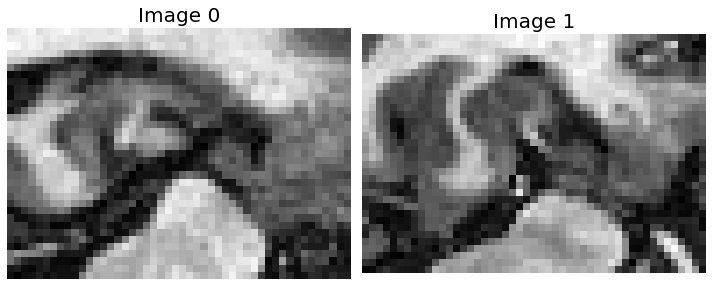

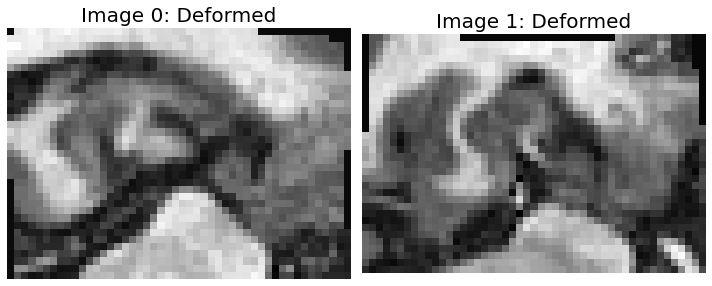

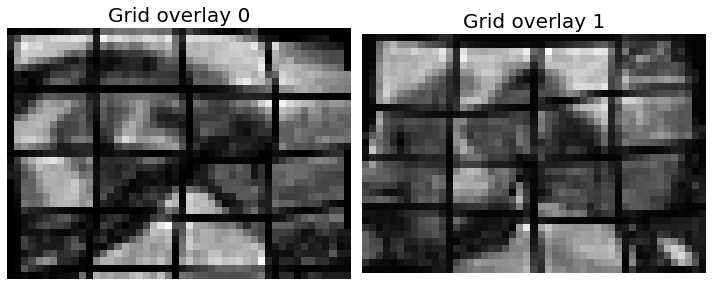

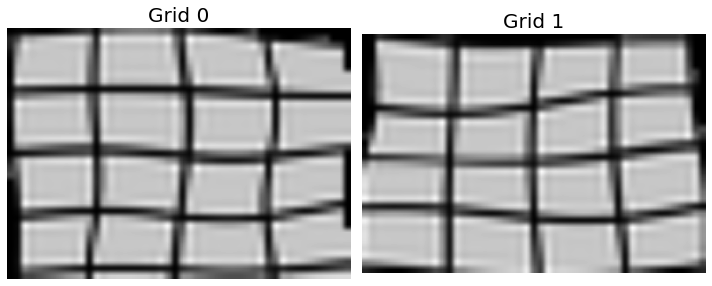

In [ ]:
import SimpleITK as sitk

def create_elastic_deformation(image, num_controlpoints, sigma):
    """
    We need to parameterise our b-spline transform
    The transform will depend on such variables as image size and sigma
    Sigma modulates the strength of the transformation
    The number of control points controls the granularity of our transform
    """
    # Create an instance of a SimpleITK image of the same size as our image
    itkimg = sitk.GetImageFromArray(np.zeros(image.shape))
    # This parameter is just a list with the number of control points per image dimensions
    trans_from_domain_mesh_size = [num_controlpoints] * itkimg.GetDimension()
    # We initialise the transform here: Passing the image size and the control point specifications
    bspline_transformation = sitk.BSplineTransformInitializer(itkimg, trans_from_domain_mesh_size)
    # Isolate the transform parameters: They will be all zero at this stage
    params = np.asarray(bspline_transformation.GetParameters(), dtype=float)
    # Let's initialise the transform by randomly initialising each parameter according to sigma
    params = params + np.random.randn(params.shape[0]) * sigma
    bspline_transformation.SetParameters(tuple(params))
    return bspline_transformation


def myshow(grid, fig_size=(10, 10)):
    grid_array = sitk.GetArrayViewFromImage(grid)
        
    plt.figure()
    plt.imshow(np.flip(grid_array, axis=0),
               interpolation='hamming',
               cmap='gray',
               origin='lower')

    
def create_grid(image):
    """
    Creates a grid to better visualise transform
    """
    grid = sitk.GridSource(outputPixelType=sitk.sitkUInt16,
    size=(image.shape[1], image.shape[0]),
    sigma=(0.0001, 0.0001),
    gridSpacing=(int(image.shape[1]/4), int(image.shape[0]/4)))
    return grid


def apply_elastic_deformation(image, num_controlpoints=5, sigma=1):
    # We need to choose an interpolation method for our transformed image, let's just go with b-spline
    resampler = sitk.ResampleImageFilter()
    resampler.SetInterpolator(sitk.sitkBSpline)
    # Let's convert our image to an sitk image
    sitk_image = sitk.GetImageFromArray(image)
    sitk_grid = create_grid(image)
    # Specify the image to be transformed: This is the reference image
    resampler.SetReferenceImage(sitk_image)
    resampler.SetDefaultPixelValue(0)
    # Initialise the transform
    bspline_transform = create_elastic_deformation(image, num_controlpoints, sigma)
    # Set the transform in the initialiser
    resampler.SetTransform(bspline_transform)
    # Carry out the resampling according to the transform and the resampling method
    out_img_sitk = resampler.Execute(sitk_image)
    out_grid_sitk = resampler.Execute(sitk_grid)
    # Convert the image back into a python array
    out_img = sitk.GetArrayFromImage(out_img_sitk)
    return out_img.reshape(image.shape), out_grid_sitk


transformed_images = []
transformed_grids = []
for image_id in range(2):
    trans_img, trans_grid = apply_elastic_deformation(dataset[image_id],
                                                      num_controlpoints=3,
                                                      sigma=2)
    transformed_images.append(trans_img)
    transformed_grids.append(trans_grid)
plot_images(dataset[:2], figsize=(10,10))
plot_images(transformed_images, title=['Deformed'], figsize=(10,10))
plot_grids_and_images(transformed_grids, transformed_images, figsize=(10,10))
plot_grids(transformed_grids, figsize=(10, 10))
#myshow(transformed_grids[0])

**To DO 2.2B: parameterising an elastic deformation**

I would like you to investigate what range of sigma is reasonable for augmenting our dataset. Remember, augmentations serve to enrich the dataset with different but *realistic* versions of existing data. Consider plotting many transformed images at once, each with a different choice of sigma.

Try modifying the number of control points: What do you observe? Is there a particular choice of number of control points that seems best suited for our images? Can you think of an example where a different choice for this variable might work better?

### Exercise 2.3 Noise augmentation
Augmenting your data with noise will make a trained network more robust to noisy unseen images. It is important to tailor your noise augmentation to the imaging modality at hand. For example, MR images exhibit [Rician distributed noise](https://en.wikipedia.org/wiki/Rice_distribution) while CT images exhibit Gaussian distributed noise. You would therefore have different forms of noise augmentation depending on if your dataset consists of MR or CT images. 

<figure align="center">
<img src="https://drive.google.com/uc?id=12znggEB9vi2GpocLLhelPpFZgNUByN7F" alt="Drawing" width="300px;"/>
</figure>

> __Figure__: If a point of distance V from the origin is selected, and points are generated indepdently following a Gaussian distribution then these points, if parameterised with respect to their distance to the origin, are Rician distributed. [Source](https://en.wikipedia.org/wiki/Rice_distribution) 
  
  
Let's augment our MR images with some Rician noise. A Rician distribution corresponds to a fourier transformed gaussian distribution. In fact, this is why MR images exhibit Rician noise, the MR signal accumulated in k-space boasts Gaussian noise, which manifests itself as Rician once the signal is converted into real space. The easiest way to implement it is to fourier transform our images, add Gaussian noise in k-space, then reverse Fourier transform the images back into real space.

It is important to note that the MR signal is composed of a *real* and *imaginary* part (See: [Real Vs Imaginary](http://mriquestions.com/real-v-imaginary.html)), a combination of two channels during the acquisition process. The noise in each channel is independant, and our code should reflect that. 

<figure align="center">
<img src="https://drive.google.com/uc?id=1K1M2YiMMg0WclvVHuINNOMLG_ir7rPxz" alt="Drawing" width="800px;"/>
</figure>

> __Figure__: Examples of *real*, *imaginary*, and *magnitude* images. [Source](http://mriquestions.com/real-v-imaginary.html) 


**To do** Complete coding of the noise augmentation (the `mr_noise_augmentation` function). This should:
1. Given an input `image`  Fourier transform it (see guidance on `np.fft` below)
2. Then, pass it to the *add_complex_noise* function (which returns a noisy k-space image), 
3. transform it back into real space through inverse fourier transform
4. Return a magnitude image. Note for complex number $z=a +ib$, where $a$ is the real component and $b$ is the imaginary component, the magnitude of $|z|=\sqrt{a^2 +b^2}$ just as for any other 2D vector space.

[The fft routine of numpy](https://docs.scipy.org/doc/numpy/reference/routines.fft.html) should prove very useful for this task (You certainly do not want to be coding a Fourier transform from scratch!).

**Note**: In reference to `add_complex_noise` (line 2). It is common to work in decibels when dealing with noise. Decibels are measured on a logarithmic scale. This makes it the unit of choice because on a linear scale noise can vary by many orders of magnitude. You can read more about the decibel scale [here](https://pulsarinstruments.com/en/post/understanding-decibels-decibel-scale-and-noise-measurement-units) if you'd like a few more details.

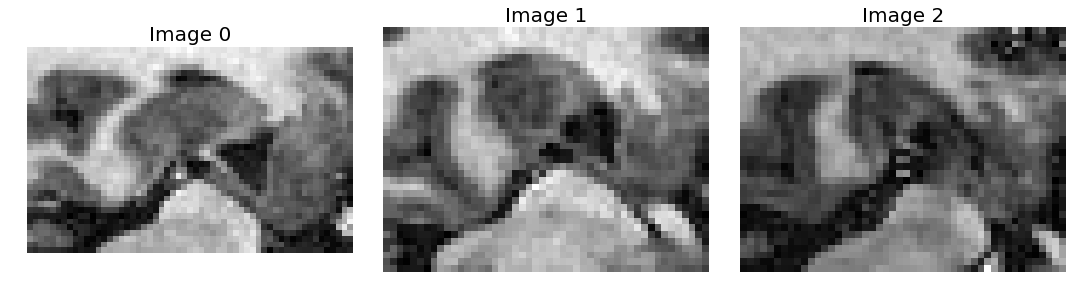

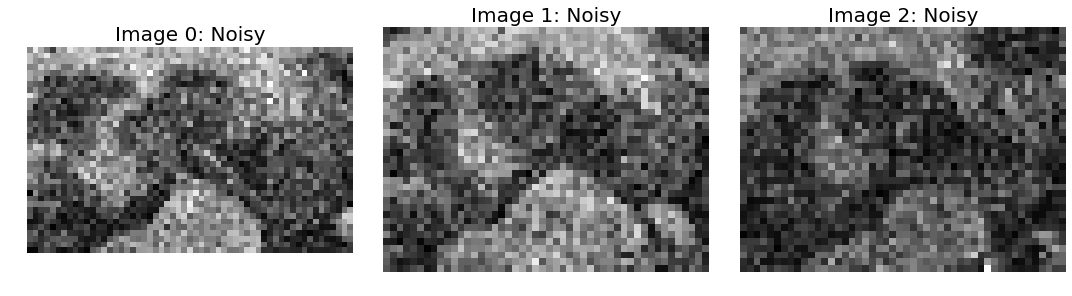

In [ ]:
def add_complex_noise(inverse_image, noise_level):
    # Convert the noise from decibels to a linear scale: See: http://www.mogami.com/e/cad/db.html
    noise_level_linear = 10 ** (noise_level / 10)
    # Real component of the noise: The noise "map" should span the entire image, hence the multiplication
    real_noise = np.sqrt(noise_level_linear / 2) * np.random.randn(inverse_image.shape[0],
                                                                   inverse_image.shape[1])
    # Imaginary component of the noise: Note the 1j term
    imaginary_noise = np.sqrt(noise_level_linear / 2) * 1j * np.random.randn(inverse_image.shape[0],
                                                                             inverse_image.shape[1])
    noisy_inverse_image = inverse_image + real_noise + imaginary_noise
    return noisy_inverse_image


def mr_noise_augmentation(image, noise_level):
    # 2.3.1 Fourier transform the input image
    inverse_image = np.fft.fftn(image)
    # 2.3.2 Add complex noise to the image in k-space
    inverse_image_noisy = add_complex_noise(inverse_image, noise_level)
    # 2.3.3 Reverse Fourier transform the image back into real space
    complex_image_noisy = np.fft.ifftn(inverse_image_noisy)
    # 2.3.4 Calculate the magnitude of the image to get something entirely real
    magnitude_image_noisy = np.sqrt(np.real(complex_image_noisy) ** 2 + np.imag(complex_image_noisy) ** 2)
    return magnitude_image_noisy


noise_augmented_images = []
for image_id in range(3):
    noise_augmented_images.append(mr_noise_augmentation(dataset[image_id], noise_level=60))
plot_images(dataset[:3])
plot_images(noise_augmented_images, title=['Noisy'])

Select different noise levels and choose different images. Does noise affect regions differently? What is the maximum tolerable noise level, qualitatively?

In [ ]:
# Coding space (If you need it)

## Exercise 2.3 Bias field augmentation

MRI images will sometimes exhibit a form of corruption termed *bias* or *intensity inhomogeneities*. They arise as a result of imperfections in the imaging pipeline, and cause low-frequency intensity changes across the image as shown in the figure below:

<figure align="center">
<img src="https://drive.google.com/uc?id=1ZlpXmBgSKE6U8qVsmtVtsQs_OcyCiX3Z" alt="Drawing" width="500px;"/>
</figure>

> __Figure__: Coronal brain slice corrupted by a bias field (Left). Corresponding bias field map (Right).  
>[A review of methods for correction of intensity inhomogeneity in MRI.](https://www.ncbi.nlm.nih.gov/pubmed/17354645)  
  
As such, the robustness of a network can be boosted by augmenting images with bias. A bias field can be modelled by the summation of polynomials up to order $N$, where $N$ is the dimensionality of the image (e.g.: $N=2$ for a $2D$ image). For $2D$, the combinations afforded to you (assuming parameterisation by x and y) are:  
  <center> $A$, $Bx$, $Cy$, $Dxy$, $Ex^2$, $Fy^2$ </center>

Where $A$, $B$, $C$, $D$, $E$, and $F$ denote random coefficients (The strength of the bias field is modulated by the magnitude of these coefficients).  

Note that the polynomials are capped at order 2 for a 2D image but the bias can be lower dimensional (i.e.: The bias field may have components in only x or only y, not necessarily both). 

**To do** 

- Go through this code line by line and check you understand what it is doing.
Experiment with the bias field strength. 
- Why would a bias field pose big challenges for medical imaging tasks (e.g.: Segmentation)? what about registration?. Answer in text box below:

**Answer:**

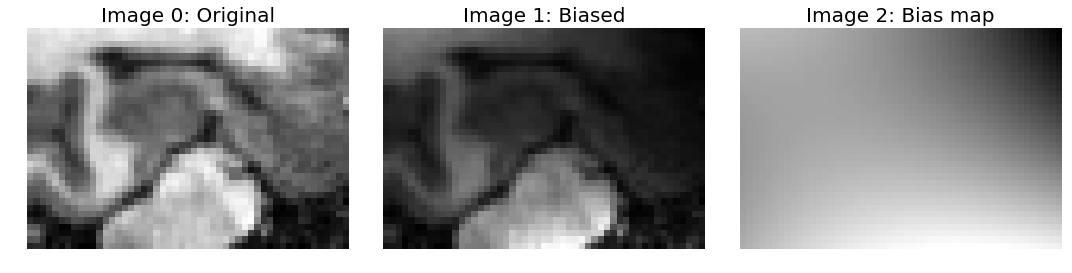

In [ ]:
# Bias field augmentation
# We're dealing with 2D images here

def apply_bias_field(image, BF_strength):
    # First of all, Calculate the dimensionality of the image
    max_order = len(image.shape)
    # Initialise the bias map as an array of zeros
    bias_map = np.zeros(image.shape)

    # we now need to create a meshed grid for x and y that span the image size
    # These are essentially just grids that denote coordinates of the image:
        # The xmesh has values increasing along x, repeated over y
        # The ymesh has values increasing along y, repeated over x

    # Array containing all values of x needed to span image in x
    x_range = np.arange(-image.shape[0]/2, image.shape[0]/2)
    # Array containing all values of y needed to span image in y
    y_range = np.arange(-image.shape[1]/2, image.shape[1]/2)
    # Create then normalise the meshes (Otherwise the bias will be too large)
    x_mesh, y_mesh = np.meshgrid(x_range, y_range)
    x_mesh = x_mesh / np.max(x_mesh)
    y_mesh = y_mesh / np.max(y_mesh)
    
    # Loop through the polynomial orders for each dimension up to max_order
    for x_order in range(max_order + 1):
        # Note: The combined polynomials can't exceed max_order, therefore ensure that y is constrained by x_order
        for y_order in range(max_order + 1 - x_order):
            # Randomly sample a coefficient for this polynomial term
            bf_coeff = np.random.uniform(-BF_strength, BF_strength)
            # Create the component of the bias produced by this polynomial
            component_bias = bf_coeff * np.power(x_mesh, x_order) * np.power(y_mesh, y_order)
            # Add the component bias to the bias_map
            bias_map += component_bias.T
    # Finally, multiply the image with the exponentiated bias map
    # Exponentiation ensures that if the BF_strength is zero then the function returns the original image
    bias_image = image * np.exp(bias_map)
    return bias_image, bias_map


# Visualisation example
image_id = np.random.randint(len(dataset))
image = dataset[image_id]
bias_image, bias_map = apply_bias_field(image, 0.75)
plot_images([image, bias_image, bias_map], title=['Original', 'Biased', 'Bias map'])

# 3 Dealing with 3D data
One of the unique challenges posed by medical images is their dimensionality; oftentimes we have datasets comprised of 3D volumes that we want to train networks on to extract useful information, but it is impossible to fit the entirety of the image into memory. We'll go over some methods of circumventing this limitation in this section.

### 2.5D data
An in-between compromise between 2D and 3D data is to resort to train your networks with "2.5D" data. There are two different ways of setting up 2.5D data:
1. Stacking multiple 2D slices of a 3D image
2. Taking 2D slices of three perpendicular planes of a 3D image

In the first instance you might still be restricted to a fairly small number of slices since there are increased resource requirements, though you would be able to employ 3D kernels to your data, thus gaining greater context awareness. For the second form you could train separate networks, each with one of the planar slice types, and combine the outputs, affording you a better prediction.  

<figure align="center">
<img src="https://drive.google.com/uc?id=1j-BWu3SRERirdQNvo_YCtTEc4M1tt78t" alt="Drawing" width="700px;"/>
</figure>

> __Figure__: Example illustrating extraction and use case of 2.5D images for a segmentation task  
>[Deep Feature Learning for Knee Cartilage
Segmentation Using a Triplanar Convolutional
Neural Network](https://link.springer.com/chapter/10.1007/978-3-642-40763-5_31)



### **Exercise 3.1 Tackling the problems associated with 3D data: Patches**
While 2.5D methods do have their uses, they are no substitute for training in full 3D. As such, it is worthwhile devising techniques that allow us to make full use of the additional dimension. In a manner not entirely dissimilar to the first form of 2.5D, we can sample sections from 3D volumes to obtain a "patch". Patches are typically isotropic and it is typically beneficial for them to be as large as the hardware will allow to maximise contextual information. However, the larger the patch the smaller the batch size has to be to account for the increased memory requirements. As such, it is often appropriate to compromise on the patch size if that allows for a significant relative increase in the size of the batch (e.g.: While you might be able to fit a patch of size 64 with batch size one, it might be worth it to decrease the patch to 56 if that meant that you can therefore double the size of the batch).

**To do** Design a simple sampler. It should take in an image and return a patch sampled from that image of size (20, 20, 20) through randomly sampling the initial coordinates in an appropriate range. 

**Note** You'll need to calculate constraints based on the size of each axis and the size of the patch - your patch must fit fully within your image. 

Complete the function below by:
1. Define the max range of coordinates - the maximum value for each axis in which a patch can start
2. Randomly selecting the starting position of the patch for each of the coordinate axis. 
3. Define the endpoints of the patch 

Your function should output the 3D patch, as well as a full image with the patch area highlighted. 

(20, 20, 20) (36, 57, 37) (57, 37)


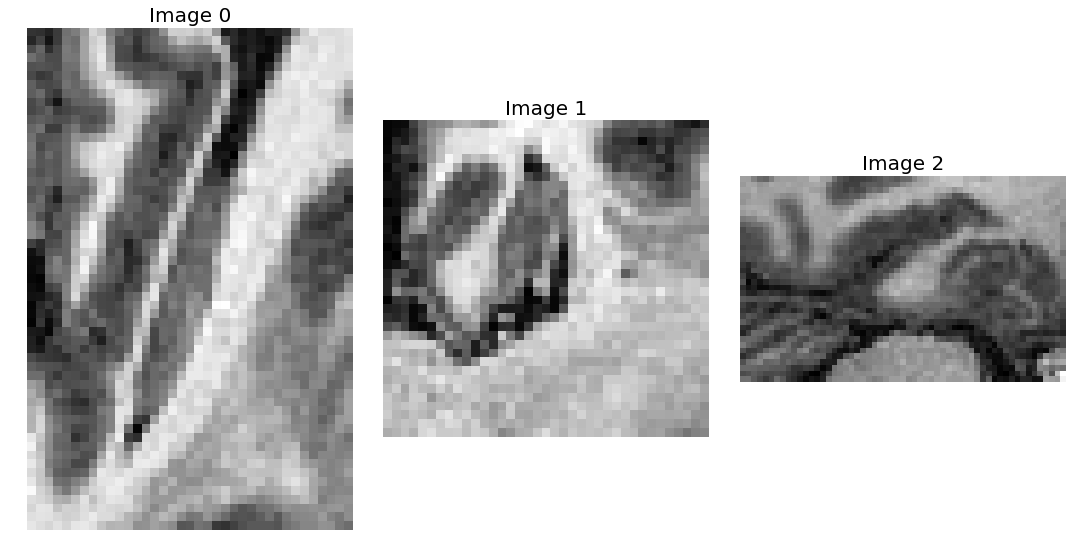

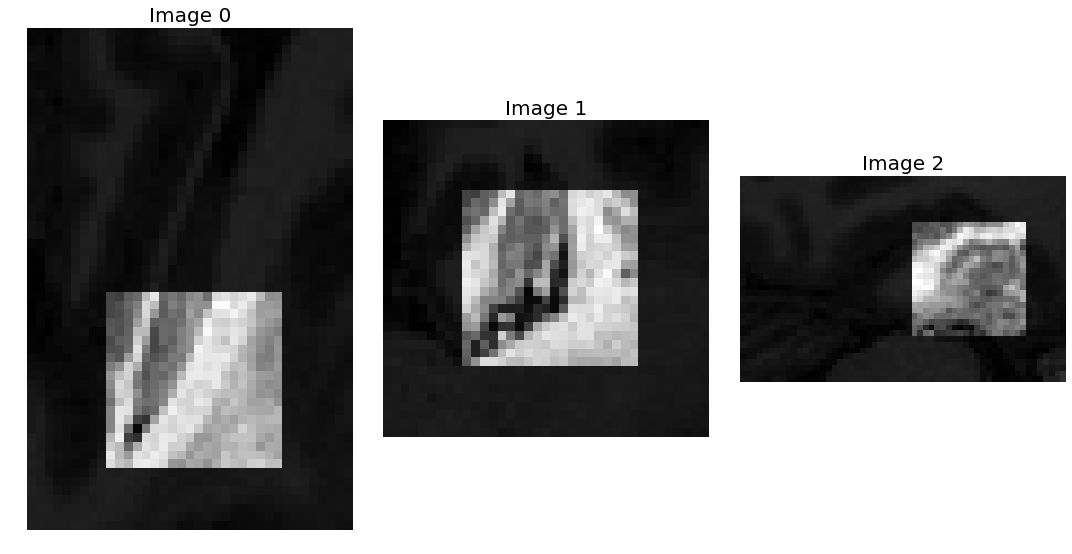

In [ ]:
# Load in the data in 3D
dataset_3D = []
data_dir = '../Task04_Hippocampus/imagesTr'
labels = os.listdir(data_dir)
for entry in range(20):
    image, _ = read_file(data_dir + '/' + labels[entry])
    dataset_3D.append(100 * image / np.max(image))

# Begin coding below
def sample_3d_patch(image, patch_size=20):
    import copy
    shape = image.shape      
    # 3.1.1 define the max range of coordinates for sampling from
    # you need to calculate constraints based on the size of each axis and the size of the patch - your patch must fit fully within your image.
    max_coords = np.array(shape) - patch_size
    starting_patch_coords = np.zeros(len(shape), dtype=np.int32)
    # 3.1.2 Randomly pick a starting point for the patch, 
    #by filling in starting_patch_coords for each dimension
    #(estimated 3 lines)
    for dim in range(len(shape)):
        # Randomly pick a starting point for the patch, for each dimension
        starting_coord = np.random.randint(0, max_coords[dim])
        starting_patch_coords[dim] = starting_coord
    # 3.1.3 Define the end_patch_coords given your starting coords
    end_patch_coords = starting_patch_coords + patch_size
    image_patch = image[starting_patch_coords[0]:end_patch_coords[0],
                        starting_patch_coords[1]:end_patch_coords[1],
                        starting_patch_coords[2]:end_patch_coords[2]]
    highlighted_image = copy.deepcopy(image)
    highlighted_image[starting_patch_coords[0]:end_patch_coords[0],
                      starting_patch_coords[1]:end_patch_coords[1],
                      starting_patch_coords[2]:end_patch_coords[2]] *= 7.5
    return image_patch, highlighted_image, starting_patch_coords

# Extract and visualise three patches for three images in the dataset
for image_id in range(1):
    image = dataset_3D[image_id]
    image_patch, highlighted_image, starting_patch_coords = sample_3d_patch(image)
    print(image_patch.shape,highlighted_image.shape,highlighted_image[starting_patch_coords[0], :, :].shape)
    plot_images([image[starting_patch_coords[0], :, :],
                 image[:, starting_patch_coords[1], :],
                 image[:, :, starting_patch_coords[2]]])
    plot_images([highlighted_image[starting_patch_coords[0], :, :],
                 highlighted_image[:, starting_patch_coords[1], :],
                 highlighted_image[:, :, starting_patch_coords[2]]])    

### **Exercise 3.2 Sampling patches**
We have been sampling our images randomly, not favouring any part of the anatomy. In practice however it might prove beneficial to force your sampler to sample more frequently from certain areas to minimise background and/or to increase the emphasis on regions that are particularly pertinent for the network to focus on. This can be accomplished with a weighted sampler.

Weighted samplers often rely on a weight map, an array the same size as the image populated by values denoting the sampling importance of any particular voxel. For a brain image, the corresponding weight map might be filled with ones in the intra-cranial region and with zeros outside of it. You would then design a sampler that takes in the image and the map and outputs patches that favour the non-zero weight regions. 

Let's create one such sampler for our hippocampus dataset. We have some hippocampus segmentations which we'll load in and use as our weight maps. The hippocampus is a fairly small region, so even in our zoomed in brain images it will take up no more than 10% of the volume. 

You will be implementing the sampler. There are many approaches to creating a sampler but let's start with something simple. 

**To do** 
- Create patches comprised by at least 20% hippocampus (as indicated by the segmentation map) 
- Assume an isotropic patch size of 20, as before. 
- one time costly but straightforward approach is to repeatedly sample patches until the criteria has been met.
- start from your existing sampler code and adapt it from there. 
- for qualitative purposes your function should also output the corresponding patch extracted from the label map.

0.131
True
0.029125
True
0.06575
True
0.200125
False


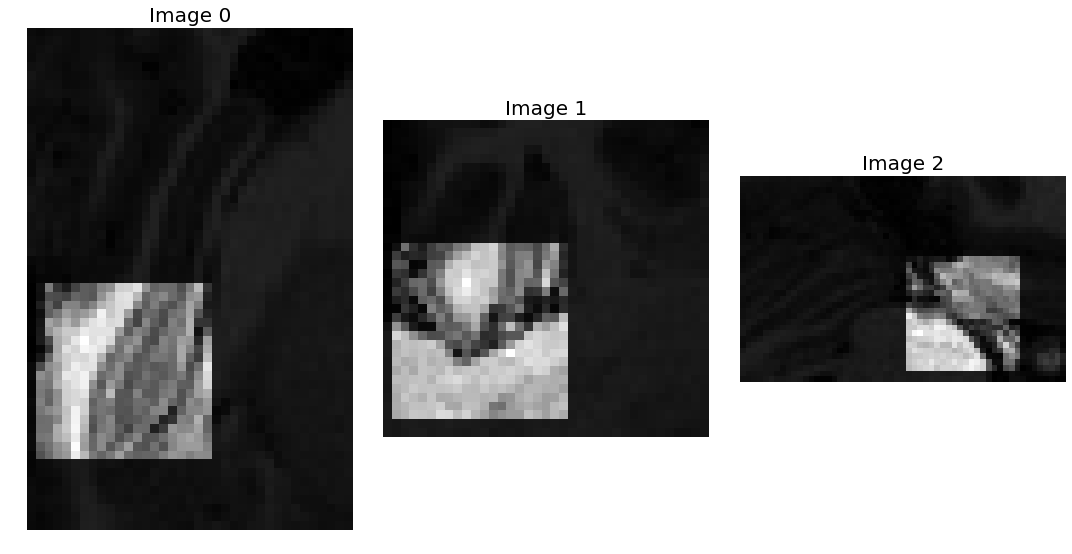

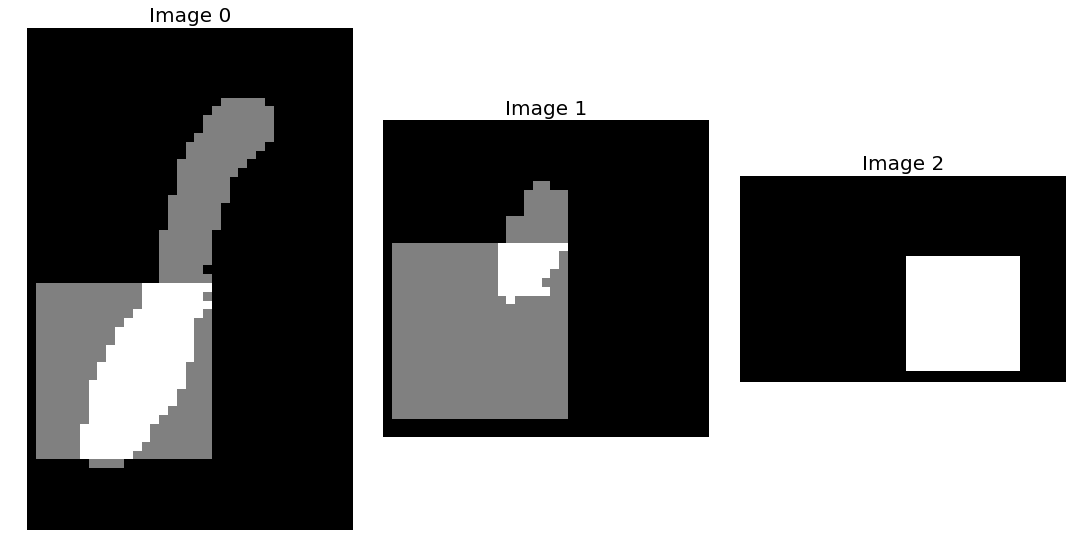

In [ ]:
# Load in the hippocampus labels: The labels should match with the 3D dataset 1:1
labels_dataset = []
data_dir = '../Task04_Hippocampus/labelsTr'
labels = os.listdir(data_dir)
for entry in range(20):
    label, _ = read_file(data_dir + '/' + labels[entry])
    label[label>1] = 1
    labels_dataset.append(label)

# Begin coding below
def sample_weighted_3d_patch(image, weight_map, patch_size=20, acceptance_threshold=0.2):
    import copy
    patch_rejection = True
    while patch_rejection:
        shape = image.shape
        max_coords = np.array(shape) - patch_size
        starting_patch_coords = np.zeros(len(shape), dtype=np.int32)
        for dim in range(len(shape)):
            # Randomly pick a starting point for the patch, for each dimension
            starting_coord = np.random.randint(0, max_coords[dim])
            starting_patch_coords[dim] = starting_coord
        end_patch_coords = starting_patch_coords + patch_size
        weight_patch = weight_map[starting_patch_coords[0]:end_patch_coords[0],
                                  starting_patch_coords[1]:end_patch_coords[1],
                                  starting_patch_coords[2]:end_patch_coords[2]]
        normalised_weight_sum = np.sum(weight_patch[:]) / weight_patch.size
        print(normalised_weight_sum)
        patch_rejection = normalised_weight_sum < acceptance_threshold
        print(patch_rejection)
    image_patch = image[starting_patch_coords[0]:end_patch_coords[0],
                        starting_patch_coords[1]:end_patch_coords[1],
                        starting_patch_coords[2]:end_patch_coords[2]]
    
    
    highlighted_image = copy.deepcopy(image)
    highlighted_label = copy.deepcopy(weight_map)
    
    highlighted_image[starting_patch_coords[0]:end_patch_coords[0],
                      starting_patch_coords[1]:end_patch_coords[1],
                      starting_patch_coords[2]:end_patch_coords[2]] *= 7.5

    label_patch = weight_map[starting_patch_coords[0]:end_patch_coords[0],
                             starting_patch_coords[1]:end_patch_coords[1],
                             starting_patch_coords[2]:end_patch_coords[2]]
    
    highlighted_label[starting_patch_coords[0]:end_patch_coords[0],
                      starting_patch_coords[1]:end_patch_coords[1],
                      starting_patch_coords[2]:end_patch_coords[2]] += 1

    return highlighted_image, highlighted_label, starting_patch_coords

# Extract and visualise three patches for three images
# Label visualisation is included for qualitative sanity check
for image_id in range(1):
    image = dataset_3D[image_id]
    weight_map = labels_dataset[image_id]
    highlighted_image, highlighted_label, starting_patch_coords = sample_weighted_3d_patch(image, weight_map)
    plot_images([highlighted_image[starting_patch_coords[0], :, :],
                 highlighted_image[:, starting_patch_coords[1], :],
                 highlighted_image[:, :, starting_patch_coords[2]]])
    plot_images([highlighted_label[starting_patch_coords[0], :, :],
                 highlighted_label[:, starting_patch_coords[1], :],
                 highlighted_label[:, :, starting_patch_coords[2]]])    

In practice this method would be quite inefficient since it relies on discarding patches that do not meet the selection criteria until one is generated that does: Can you think of better methods? 